# National Flag Recognition
**Steps...**
<b>
    1. Download The Data
    2. Process the directory 
    3. Import Necessary library
    4. Making the model
    5. Optimizer and Annealer
    6. Data Augmentation
    7. Model Preperation
        7.1. Model Train
        7.2. Model Save
    8. Training and validation curves
    9. Check New Image

## 1. Download the data
Lets, download the data from the github. If you already downloaded the data no need to run the cell. 
*Note: This command is for unix*

In [0]:
!wget https://github.com/ShahariarRabby/National-Flag-Detection/raw/master/10_country_train_1.zip
!wget https://github.com/ShahariarRabby/National-Flag-Detection/raw/master/10_country_train_2.zip
!wget https://raw.githubusercontent.com/ShahariarRabby/National-Flag-Detection/master/10_country_test.zip

## 2. Process the directory
Unzipped the data and save the training data in one folder.

In [0]:
!unzip 10_country_train_1.zip
!unzip 10_country_train_2.zip
!unzip 10_country_test.zip
!cp -r ./10_country_train_1/* ./10_country_train_2 && rm -R ./10_country_train_1/*

## 3. Import Necessary library

In [3]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import  confusion_matrix

from __future__ import print_function

import keras
from keras import backend as K
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.models import load_model
from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import model_to_dot
from keras.utils.generic_utils import get_custom_objects
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from keras.layers import Activation, Add, BatchNormalization, Dropout

Using TensorFlow backend.


## 4. Define the model
I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.
Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="sigmoid")) the net outputs distribution of probability of each class.

In [4]:
# Set the CNN model 

model = Sequential()


model.add(Conv2D(activation ='relu', input_shape = (64,64,3), filters=64, kernel_size=(3, 3), padding="SAME", strides=(1, 1)))
model.add(Conv2D(activation ='relu',filters=64, kernel_size=(3, 3), padding="SAME", strides=(1,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))


model.add(Conv2D(activation ='relu', filters=512, kernel_size=(3, 3), padding="SAME", strides=(1, 1)))
model.add(Conv2D(activation ='relu', filters=512, kernel_size=(3, 3), padding="SAME", strides=(1, 1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))


model.add(Conv2D(activation ='relu', filters=256, kernel_size=(3, 3), padding="SAME", strides=(1, 1)))
model.add(Conv2D(activation ='relu', filters=256, kernel_size=(3, 3), padding="SAME", strides=(1, 1)))
model.add(Conv2D(activation ='relu', filters=256, kernel_size=(3, 3), padding="SAME", strides=(1, 1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))


model.add(Conv2D(activation ='relu', filters=128, kernel_size=(3, 3), padding="SAME", strides=(1, 1)))
model.add(Conv2D(activation ='relu', filters=128, kernel_size=(3, 3), padding="SAME", strides=(1, 1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))



model.add(Flatten())
model.add(Dense(units = 100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 10, activation='softmax', kernel_initializer='uniform'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 512)       295424    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 512)       2359808   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       1179904   
__________

## 5. Optimizer and Annealer
Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed adam (with default values), This is used to perform optimization and is one of the best optimizer at present. The author claims that it inherits from RMSProp and AdaGrad (Well it inherits from them).

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [0]:
# Define the optimizer
optimizer = Adam(lr=0.001)

In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=["accuracy"])


In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## 6. Data augmentation
In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [0]:
train_datagen = ImageDataGenerator(
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')


test_datagen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [9]:
train_generator = train_datagen.flow_from_directory(
                                                    '10_country_train_2/train/',
                                                    target_size=(64, 64),
                                                    batch_size=30,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
                                                    '10_country_test/test',
                                                    target_size=(64, 64),
                                                    batch_size=30,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 4283 images belonging to 10 classes.
Found 1049 images belonging to 10 classes.


In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## 7. Train The model for 50 Epoc

In [11]:
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=4283 /30,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1,
                    callbacks=[learning_rate_reduction])

Epoch 1/50
143/142 [==============================] - 39s 270ms/step - loss: 2.3001 - acc: 0.1283 - val_loss: 2.1511 - val_acc: 0.2355
Epoch 2/50
143/142 [==============================] - 32s 227ms/step - loss: 1.7114 - acc: 0.3430 - val_loss: 1.0987 - val_acc: 0.5430
Epoch 3/50
143/142 [==============================] - 33s 228ms/step - loss: 1.0616 - acc: 0.5688 - val_loss: 0.8509 - val_acc: 0.6651
Epoch 4/50
143/142 [==============================] - 33s 228ms/step - loss: 0.9485 - acc: 0.6554 - val_loss: 0.7565 - val_acc: 0.7151
Epoch 5/50
143/142 [==============================] - 32s 225ms/step - loss: 0.7584 - acc: 0.7380 - val_loss: 0.5758 - val_acc: 0.8012
Epoch 6/50
143/142 [==============================] - 32s 226ms/step - loss: 0.6542 - acc: 0.7596 - val_loss: 0.4458 - val_acc: 0.8379
Epoch 7/50
143/142 [==============================] - 33s 229ms/step - loss: 0.6403 - acc: 0.7746 - val_loss: 0.4818 - val_acc: 0.8219
Epoch 8/50
143/142 [==============================] - 3

## 8. Training and validation curves
The code below is for plotting loss and accuracy curves for training and validation. 

The model reaches almost 98% (98.2+%) accuracy on the validation dataset after 50 epochs. The diffrence between validation accuracy and the training accuracy almost same every time during the training. That means that our model dosen't not overfit the training set.

Our model is very well trained !!!

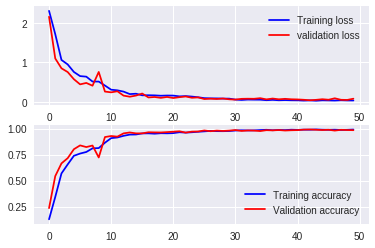

In [12]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 10. Check New Image

In [15]:
from keras.preprocessing import image

test = image.load_img('10_country_test/test/Argentina/0 (1).jpg',
                      target_size=(64, 64))
test = image.img_to_array(test)
test = np.expand_dims(test, axis=0)

print(model.predict(test))
print(train_generator.class_indices)

[[1.56592730e-29 4.52052040e-09 1.38192875e-14 6.20377192e-04
  2.81864475e-03 4.75782933e-13 9.43619938e-08 1.86119452e-02
  1.50168953e-33 9.77948904e-01]]
{'Argentina': 0, 'Australia': 1, 'Brazil': 2, 'China': 3, 'Germany': 4, 'Japan': 5, 'Mexico': 6, 'Russia': 7, 'Saudi Arabia': 8, 'Spain': 9}


### Thank You